# Asymmetry

This notebook hopes to find a way to redefine asymmetry. I trial two test cases - WASP 100 for the Exoplanet transit, and the Exocomet transit from Beta Pic. Data is taken from the shared Google Bucket, so will not work unless you have these specific lightcurves. Improvements in progress. The "search" part of my research has been stripped down so hence why there's code repetition.

In [2]:
import os

os.chdir("../")
import lightkurve as lk
from matplotlib import pyplot as plt
import numpy as np
from astropy.table import Table
from analysis_tools_cython import *
import scipy.integrate as integrate
import numpy as np
from scipy.signal import savgol_filter

plt.rcParams["figure.figsize"] = (20, 10)

### Functions

In [4]:
def skewed_gaussian_curve_fit(x, y):
    # Initial parameters guess
    ## i = index of min time
    ## x = time
    ## y = flux

    i = np.argmin(y)

    ### params initialisation for skewness, time, mean and sigma
    params_init = [4, x[i], 0.2, 0.0006]

    params_bounds = [[0, x[0], 0, 0], [np.inf, x[-1], np.inf, np.inf]]
    params, cov = curve_fit(
        updated_skewed_gauss, x, y, p0=params_init, maxfev=1000000
    )  # ,bounds=params_bounds)
    return params, cov

## 1. WASP 100 in XRP data

In [5]:
lookup = pd.read_csv("/storage/astro2/phrdhx/tesslcs/sector1lookup.csv")

In [69]:
lookup[lookup.TIC_ID == 50380257]

,Filename,RA,Dec,TIC_ID,Sector,Camera,CCD,Magnitude
294,tesslcs_sector_1_104/2_min_cadence_targets/tes...,12.089498,-66.160271,39018208,1,3,1,11.1032


### 1.1 Reading in the lightcurve and cleaning

In [85]:
data, lc_info = import_XRPlightcurve(
    "/storage/astro2/phrdhx/tesslcs/tesslcs_sector_1_104/2_min_cadence_targets/tesslc_50380257.pkl",
    sector=1,
)
# plt.plot(data['time'],data['corrected flux'])

In [86]:
data = data["time", "corrected flux", "quality", "flux error"]

flat_flux, trend_flux = smoothing(data, method="median")
a = Table()
a["time"] = data[data.colnames[0]]
a["flux"] = flat_flux - np.ones(len(flat_flux))
a["quality"] = data[data.colnames[2]]
a["flux_error"] = data[data.colnames[3]]
# table[table.colnames[1]] = flat_flux - np.ones(len(flat_flux)) # resets normalisation to zero instead of one.
t, flux, quality, real, flux_error = clean_data(a)
flux *= real

### 1.2 My automated search

In [87]:
timestep = calculate_timestep(data)
factor = (1 / 48) / timestep

T1 = test_statistic_array(flux, 60 * factor)

m, n = np.unravel_index(
    T1.argmin(), T1.shape
)  # T.argmin(): location of  T.shape: 2D array with x,y points in that dimension
minT = T1[m, n]
# Ts = nonzero(T1[m,n]).std()
minT_time = t[n]
minT_duration = m * timestep
Tm_start = n - math.floor((m - 1) / 2)
Tm_end = Tm_start + m
Tm_depth = flux[Tm_start:Tm_end].mean()
Ts = nonzero(T1[m]).std()  # only the box width selected. Not RMS of all T-statistic

### 1.3 Creating the cutout of the deepest event

In [88]:
asym, width1, width2, depth, info = calc_shape(
    m, n, t, flux, quality, flux_error, n_m_bg_start=2
)
s = classify(m, n, real, asym)

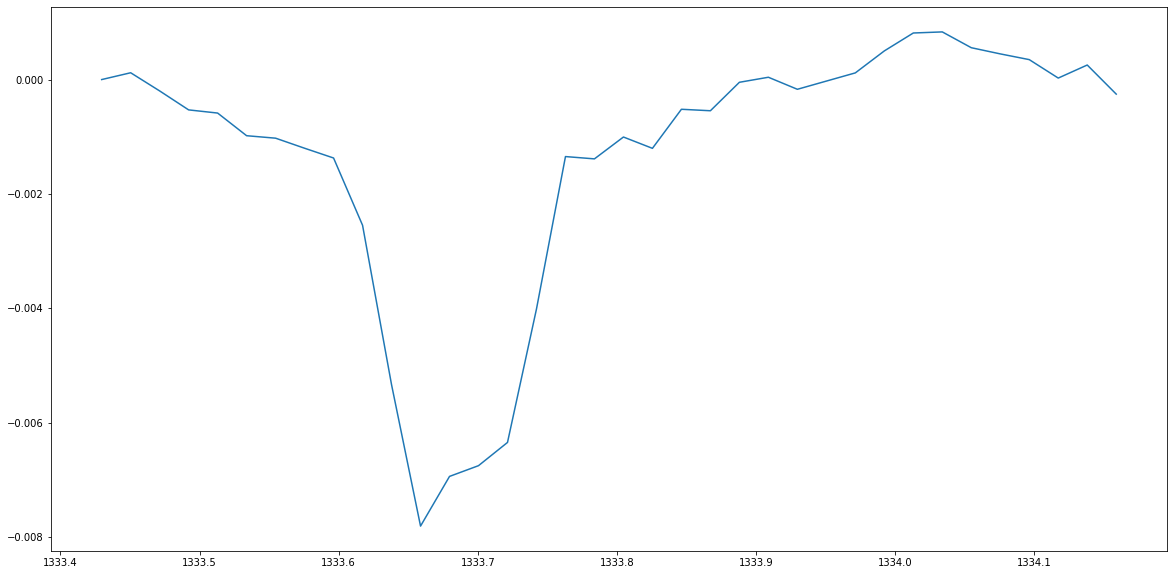

In [89]:
plt.plot(info[0], info[1])

In [90]:
t = info[0]
flux = info[1]

In [98]:
params, cov = single_gaussian_curve_fit(t, -flux)
params1, cov1 = skewed_gaussian_curve_fit(t, flux)

In [99]:
params1

array([1.40417495e+00, 1.33364215e+03, 6.92613789e-02, 9.83178443e-04])

In [100]:
fit = -gauss(t, *params)
fit2 = updated_skewed_gauss(t, *params1)

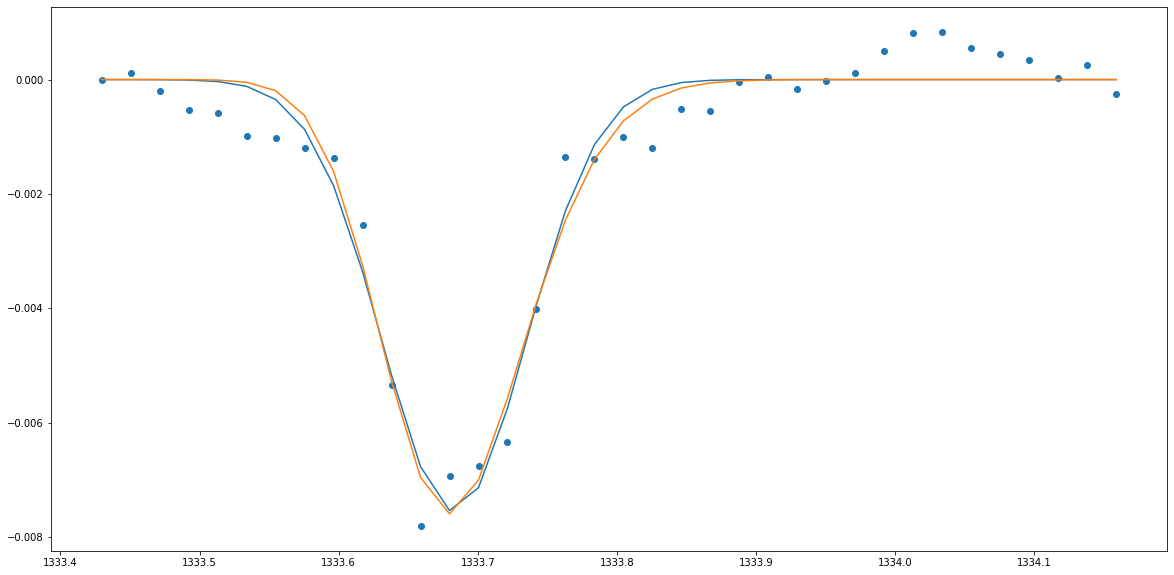

In [101]:
plt.scatter(info[0], info[1])
plt.plot(info[0], fit)
plt.plot(info[0], fit2)

In [103]:
params1, np.diag(cov1)

(array([1.40417495e+00, 1.33364215e+03, 6.92613789e-02, 9.83178443e-04]),
 array([3.65512728e-01, 9.44071198e-05, 8.81830203e-05, 1.79109011e-09]))

### 1.4 Flipping the lightcurves

For a test scenario, we flip the lightcurve based on the minimum point of this cutout, since we know the strongest event to be the transiting event and the midtransit point is where the data appears the lowest. However, I am aware that there can be the case where the minimum point is an outliter. So I need to think about that. But for now, we continue this way.

In [11]:
# plt.rcParams['axes.xlabel'] = 'time from midtransit in BTJD'

In [12]:
t = info[0]
flux = info[1]

In [13]:
min_flux_ind = np.argmin(flux)
min_time = info[-1]

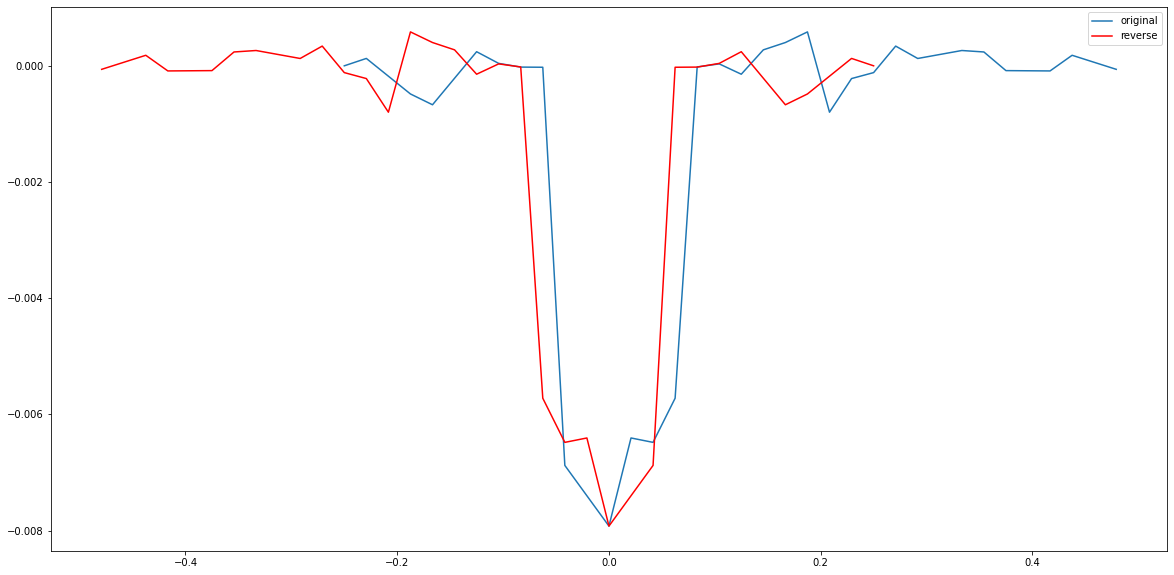

In [14]:
plt.figure(figsize=(20, 10))
plt.plot(t - t[min_flux_ind], flux, label="original")


# plt.plot(t - t[min_flux_ind],np.roll(flux,5),color='blue',label='original shifted')
# plt.plot(time - time[min_flux_ind],flux,color='black',label='original')
plt.plot(t[::-1] - t[np.argmin(flux[::-1])], flux, color="red", label="reverse")
plt.legend()

In [15]:
x_forward = t - min_time
y_forward = flux
y_forward_filtered = savgol_filter(flux, 15, 2)

In [16]:
x_backward = (t[::-1] - t[np.argmin(flux[::-1])])[::-1]
y_backward = flux[::-1]
y_backward_filtered = savgol_filter(flux[::-1], 15, 2)

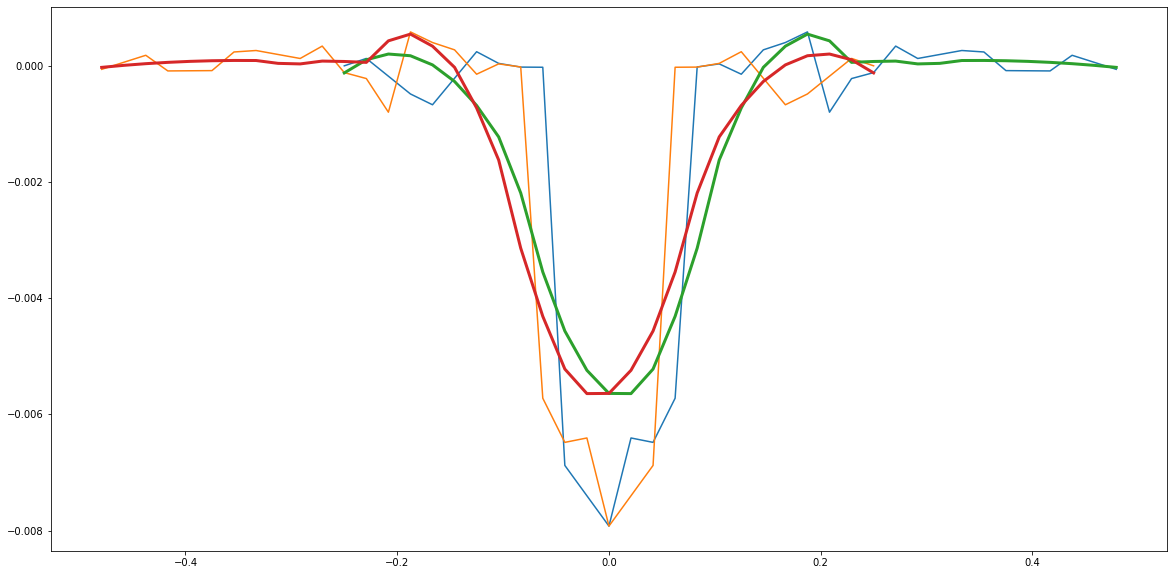

In [17]:
plt.figure(figsize=(20, 10))
plt.plot(x_forward, y_forward)
plt.plot(x_backward, y_backward)
plt.plot(x_forward, y_forward_filtered, linewidth=3)
plt.plot(x_backward, y_backward_filtered, linewidth=3)

### 1.5 Now we interpolate the data, and subtract the two lightcurves

In [18]:
t = np.linspace(-2, 2, 5000)

diff = np.interp(t, x_forward, y_forward_filtered) - np.interp(
    t, x_backward, y_backward_filtered
)

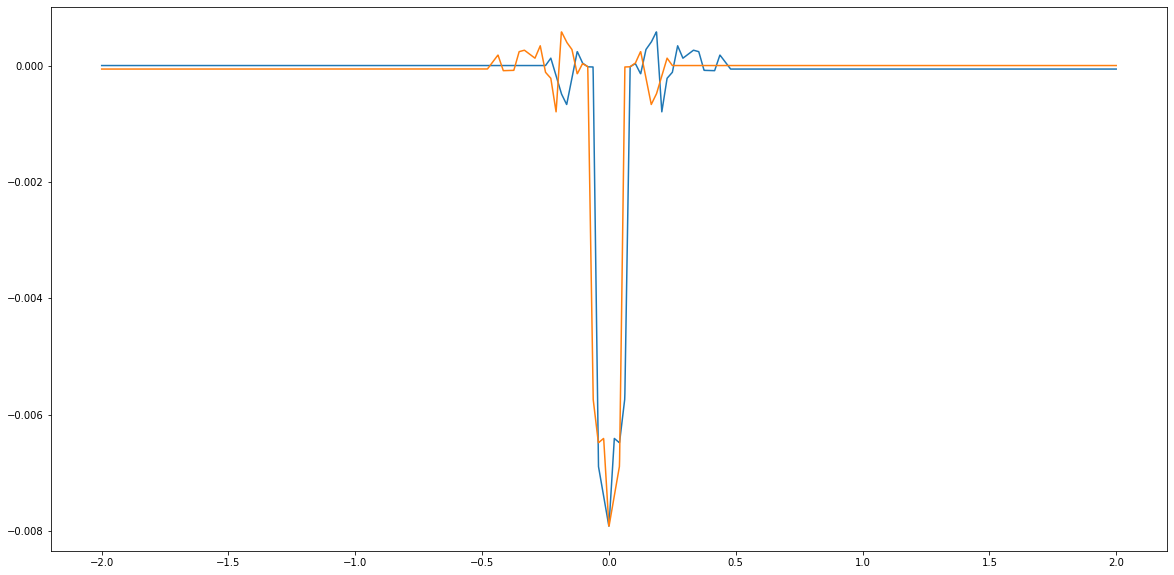

In [19]:
plt.plot(t, np.interp(t, x_forward, y_forward))
plt.plot(t, np.interp(t, x_backward, y_backward))

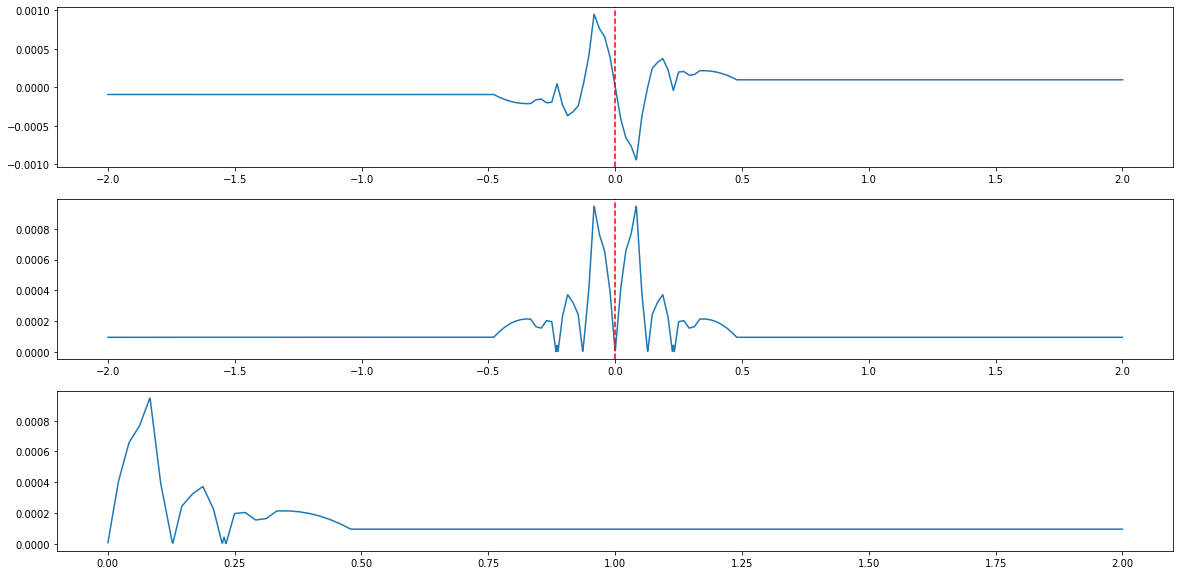

In [20]:
fig, ax = plt.subplots(3)
ax[0].plot(t, diff)
ax[0].axvline(0, linestyle="--", color="red")
ax[1].plot(t, abs(diff))
ax[1].axvline(0, linestyle="--", color="red")
ax[2].plot(t[2500:], abs(diff)[2500:])

### 1.6 Integrating `diff`(?)

In [21]:
np.mean(diff[2500:])

7.240137269563079e-05

In [22]:
integrate.simps(abs(diff[2500:]))

0.34757518055931397

---

## 2 Exocomet test

In [23]:
data, lc_info = import_lightcurve(
    "betapic/test/hlsp_tess-spoc_tess_phot_0000000270577175-s0006_tess_v1_lc.fits"
)

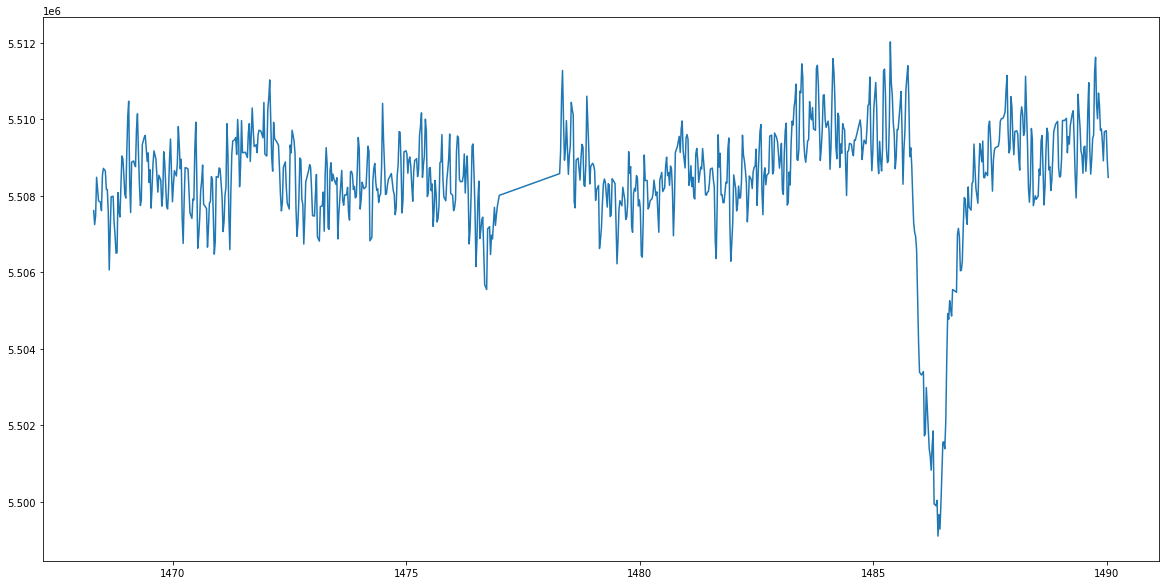

In [24]:
plt.plot(data["TIME"], data["PDCSAP_FLUX"])

In [25]:
# data = data['time','corrected flux','quality','flux error']

flat_flux, trend_flux = smoothing(data, method="median")
a = Table()
a["time"] = data[data.colnames[0]]
a["flux"] = flat_flux - np.ones(len(flat_flux))
a["quality"] = data[data.colnames[2]]
a["flux_error"] = data[data.colnames[3]]
# table[table.colnames[1]] = flat_flux - np.ones(len(flat_flux)) # resets normalisation to zero instead of one.
t, flux, quality, real, flux_error = clean_data(a)
flux *= real

### 2.1 My automated search

In [26]:
timestep = calculate_timestep(data)
factor = (1 / 48) / timestep

T1 = test_statistic_array(flux, 60 * factor)

m, n = np.unravel_index(
    T1.argmin(), T1.shape
)  # T.argmin(): location of  T.shape: 2D array with x,y points in that dimension
minT = T1[m, n]
# Ts = nonzero(T1[m,n]).std()
minT_time = t[n]
minT_duration = m * timestep
Tm_start = n - math.floor((m - 1) / 2)
Tm_end = Tm_start + m
Tm_depth = flux[Tm_start:Tm_end].mean()
Ts = nonzero(T1[m]).std()  # only the box width selected. Not RMS of all T-statistic

### 2.2 Creating the cutout of the deepest event

In [27]:
asym, width1, width2, depth, info = calc_shape(
    m, n, t, flux, quality, flux_error, n_m_bg_start=2
)
s = classify(m, n, real, asym)

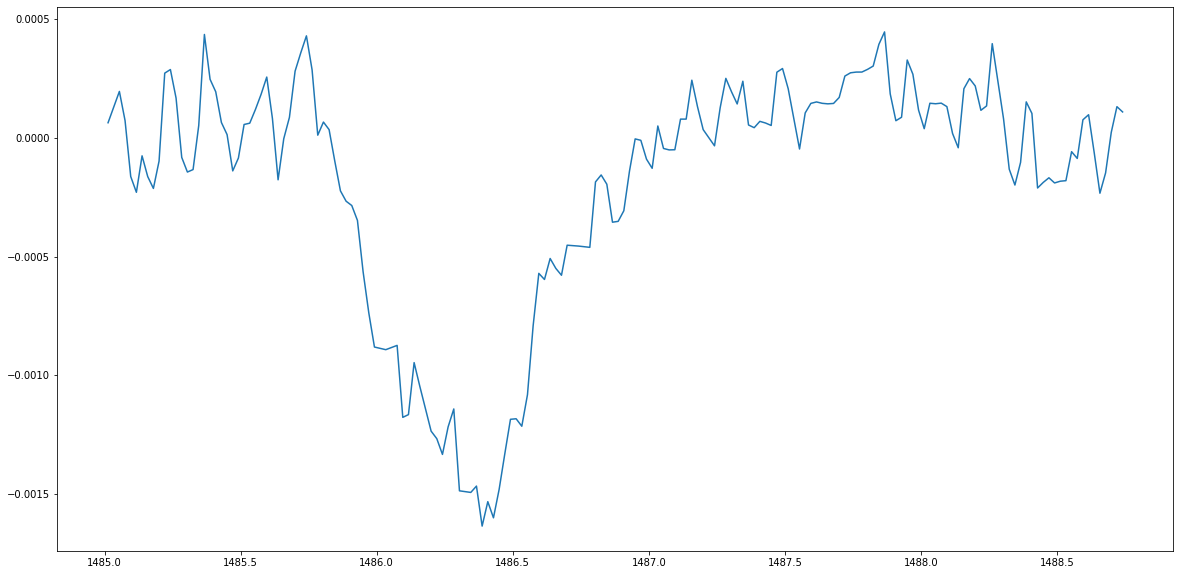

In [28]:
plt.plot(info[0], info[1])

In [29]:
min_time = info[-1]

In [30]:
t = info[0]
flux = info[1]

### 2.3 Flipping the lightcurves - Tried with Savgol applied too


In [31]:
min_flux_ind = np.argmin(flux)

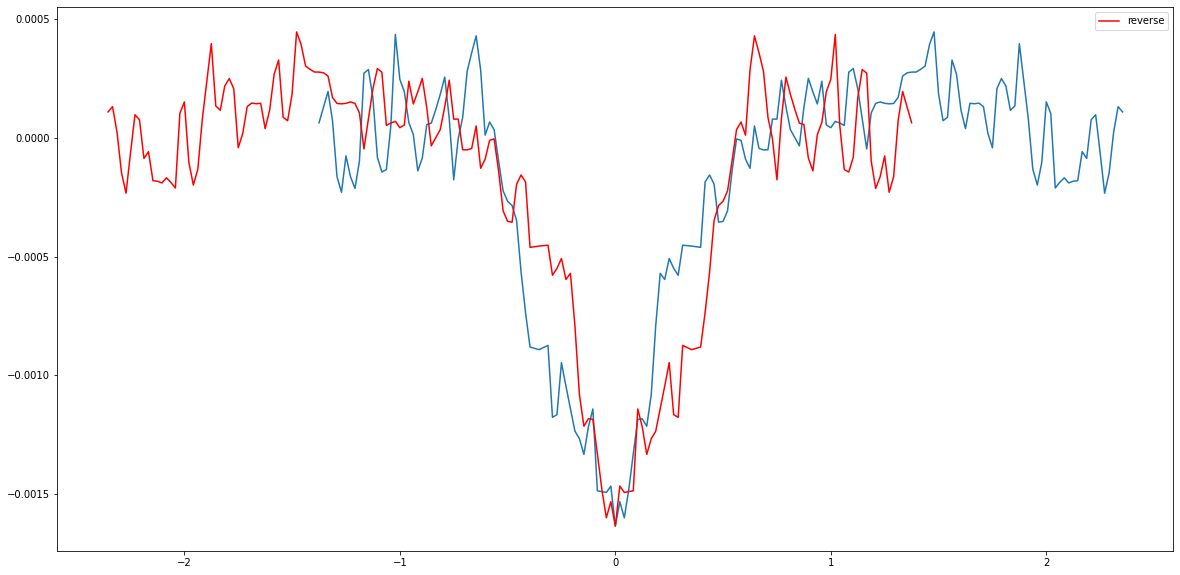

In [32]:
plt.figure(figsize=(20, 10))
plt.plot(t - min_time, flux)


# plt.plot(t - t[min_flux_ind],np.roll(flux,5),color='blue',label='original shifted')
# plt.plot(time - time[min_flux_ind],flux,color='black',label='original')
plt.plot(t[::-1] - t[np.argmin(flux[::-1])], flux, color="red", label="reverse")
plt.legend()

In [33]:
x_forward = t - min_time
y_forward = flux
y_forward_filtered = savgol_filter(flux, 15, 2)

In [34]:
x_backward = (t[::-1] - t[np.argmin(flux[::-1])])[::-1]
y_backward = flux[::-1]
y_backward_filtered = savgol_filter(flux[::-1], 15, 2)

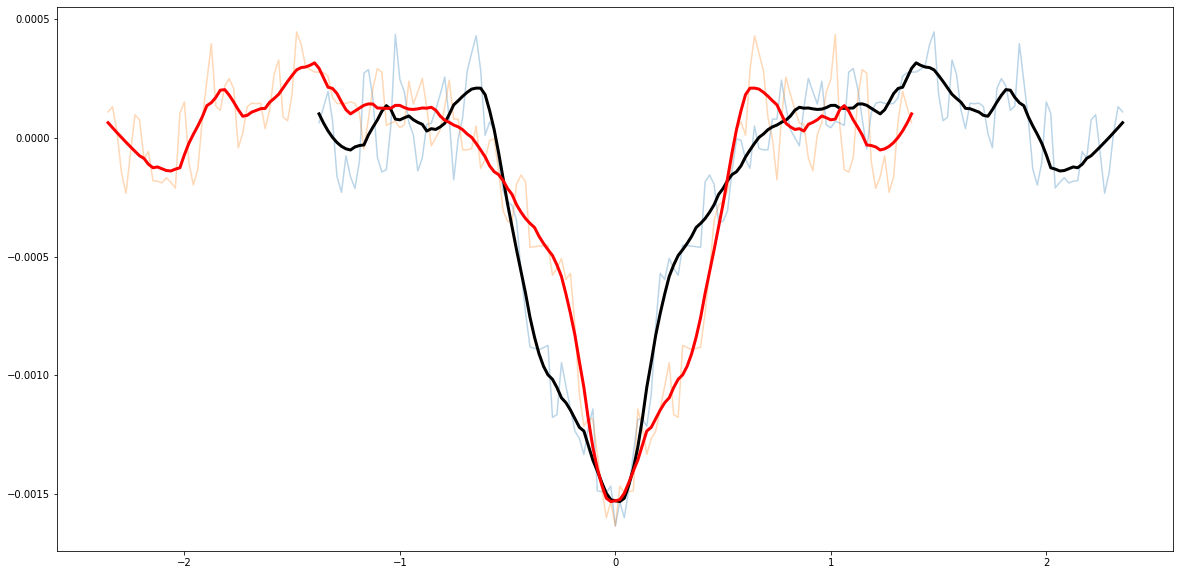

In [35]:
plt.figure(figsize=(20, 10))
plt.plot(x_forward, y_forward, alpha=0.3)
plt.plot(x_backward, y_backward, alpha=0.3)
plt.plot(x_forward, y_forward_filtered, linewidth=3, color="black")
plt.plot(x_backward, y_backward_filtered, linewidth=3, color="red")

### 2.4 Interpolating and subtracting

In [36]:
ti = np.linspace(-2, 2, 5000)
diff = np.interp(ti, x_forward, y_forward) - np.interp(ti, x_backward, y_backward)

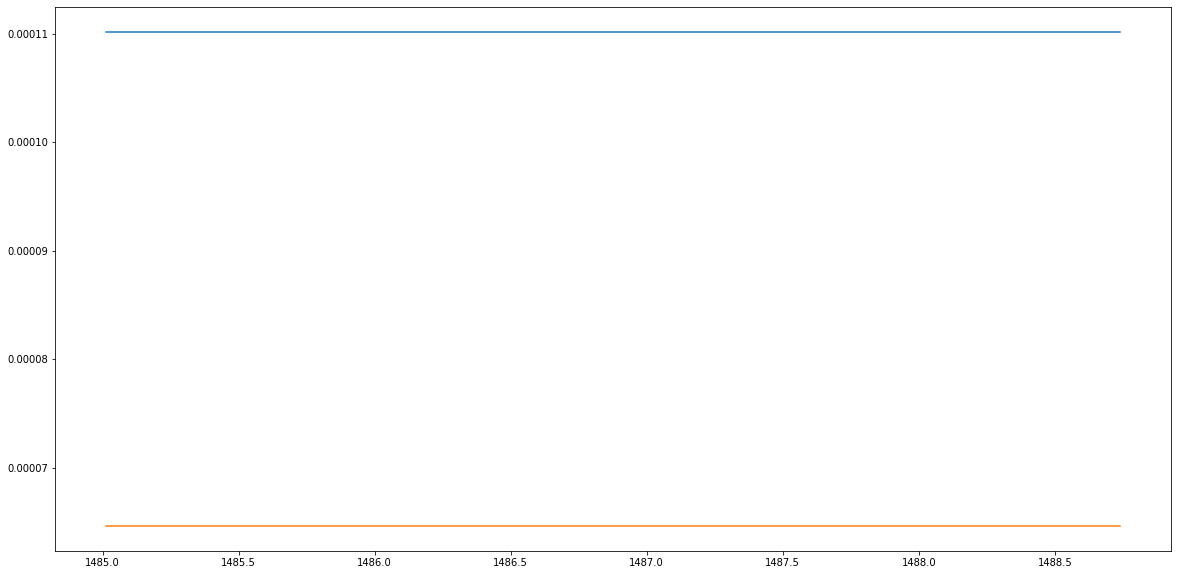

In [37]:
plt.plot(t, np.interp(t, x_forward, y_forward))
plt.plot(t, np.interp(t, x_backward, y_backward))

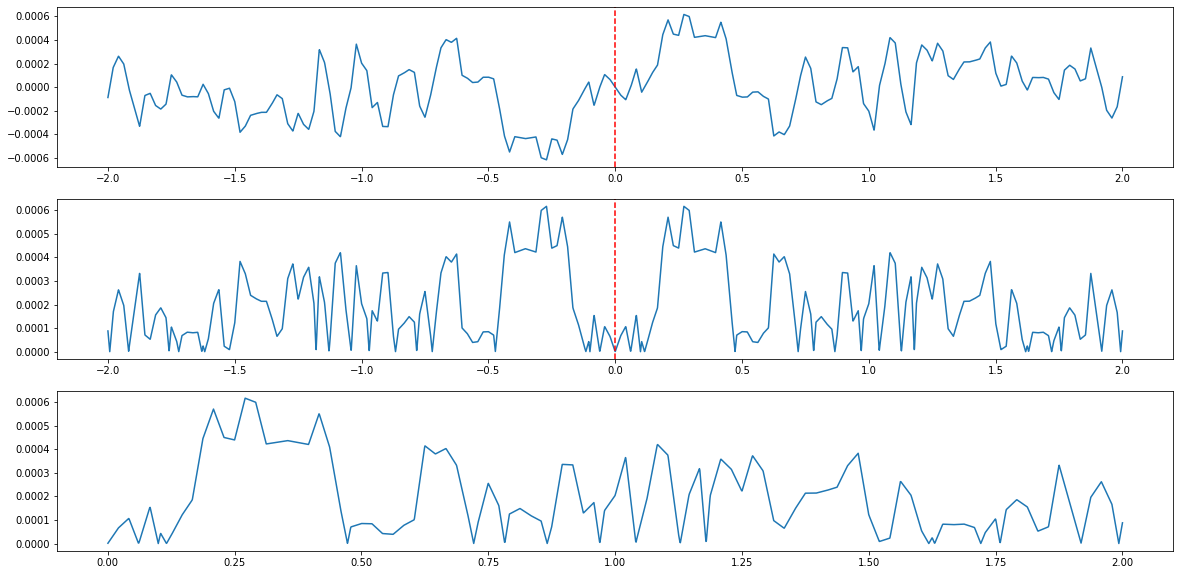

In [38]:
fig, ax = plt.subplots(3)
ax[0].plot(ti, diff)
ax[0].axvline(0, linestyle="--", color="red")
ax[1].plot(ti, abs(diff))
ax[1].axvline(0, linestyle="--", color="red")
ax[2].plot(ti[2500:], abs(diff)[2500:])

In [39]:
np.mean(diff[2500:])

0.00010826990500451304

In [40]:
np.max(diff[2500:])

0.0006165585811697401

### 2.5 Integrating diff(?)

In [41]:
integrate.trapz(abs(diff))

1.0152920594144104

In [42]:
integrate.simps(abs(diff)[2500:])

0.5076434413769114

---

## 3. Alternative Skewness
### 3.1 Exoplanet case

In [43]:
data, lc_info = import_XRPlightcurve(
    "/storage/astro2/phrdhx/tesslcs/tesslcs_sector_1_104/2_min_cadence_targets/tesslc_38846515.pkl",
    sector=1,
)

In [44]:
data = data["time", "corrected flux", "quality", "flux error"]

flat_flux, trend_flux = smoothing(data, method="median")
a = Table()
a["time"] = data[data.colnames[0]]
a["flux"] = flat_flux - np.ones(len(flat_flux))
a["quality"] = data[data.colnames[2]]
a["flux_error"] = data[data.colnames[3]]
# table[table.colnames[1]] = flat_flux - np.ones(len(flat_flux)) # resets normalisation to zero instead of one.
t, flux, quality, real, flux_error = clean_data(a)
flux *= real

### 3.1.2 My automated search

In [45]:
timestep = calculate_timestep(data)
factor = (1 / 48) / timestep

T1 = test_statistic_array(flux, 60 * factor)

m, n = np.unravel_index(
    T1.argmin(), T1.shape
)  # T.argmin(): location of  T.shape: 2D array with x,y points in that dimension
minT = T1[m, n]
# Ts = nonzero(T1[m,n]).std()
minT_time = t[n]
minT_duration = m * timestep
Tm_start = n - math.floor((m - 1) / 2)
Tm_end = Tm_start + m
Tm_depth = flux[Tm_start:Tm_end].mean()
Ts = nonzero(T1[m]).std()  # only the box width selected. Not RMS of all T-statistic

### 3.1.2 Creating the cutout of the deepest event

In [46]:
asym, width1, width2, depth, info = calc_shape(
    m, n, t, flux, quality, flux_error, n_m_bg_start=2
)
s = classify(m, n, real, asym)

In [47]:
t = info[0]
flux = info[1]

In [48]:
skewness = 3 * (np.mean(flux) - np.median(flux)) / np.std(flux)
skewness

-1.2799185015472339

### 3.2 Second Exoplanet case

In [33]:
data, lc_info = import_XRPlightcurve(
    "/storage/astro2/phrdhx/tesslcs/tesslcs_sector_1_104/2_min_cadence_targets/tesslc_261136679.pkl",
    sector=1,
)

In [34]:
data = data["time", "corrected flux", "quality", "flux error"]

flat_flux, trend_flux = smoothing(data, method="median")
a = Table()
a["time"] = data[data.colnames[0]]
a["flux"] = flat_flux - np.ones(len(flat_flux))
a["quality"] = data[data.colnames[2]]
a["flux_error"] = data[data.colnames[3]]
# table[table.colnames[1]] = flat_flux - np.ones(len(flat_flux)) # resets normalisation to zero instead of one.
t, flux, quality, real, flux_error = clean_data(a)
flux *= real

### 3.2.1 My automated search

In [35]:
timestep = calculate_timestep(data)
factor = (1 / 48) / timestep

T1 = test_statistic_array(flux, 60 * factor)

m, n = np.unravel_index(
    T1.argmin(), T1.shape
)  # T.argmin(): location of  T.shape: 2D array with x,y points in that dimension
minT = T1[m, n]
# Ts = nonzero(T1[m,n]).std()
minT_time = t[n]
minT_duration = m * timestep
Tm_start = n - math.floor((m - 1) / 2)
Tm_end = Tm_start + m
Tm_depth = flux[Tm_start:Tm_end].mean()
Ts = nonzero(T1[m]).std()  # only the box width selected. Not RMS of all T-statistic

### 3.2.2 Creating the cutout of the deepest event

In [36]:
asym, width1, width2, depth, info = calc_shape(
    m, n, t, flux, quality, flux_error, n_m_bg_start=2
)
s = classify(m, n, real, asym)

In [37]:
t = info[0]
flux = info[1]

---

### 3.3 Exocomet case

In [132]:
data, lc_info = import_lightcurve(
    "betapic/test/hlsp_tess-spoc_tess_phot_0000000270577175-s0006_tess_v1_lc.fits"
)

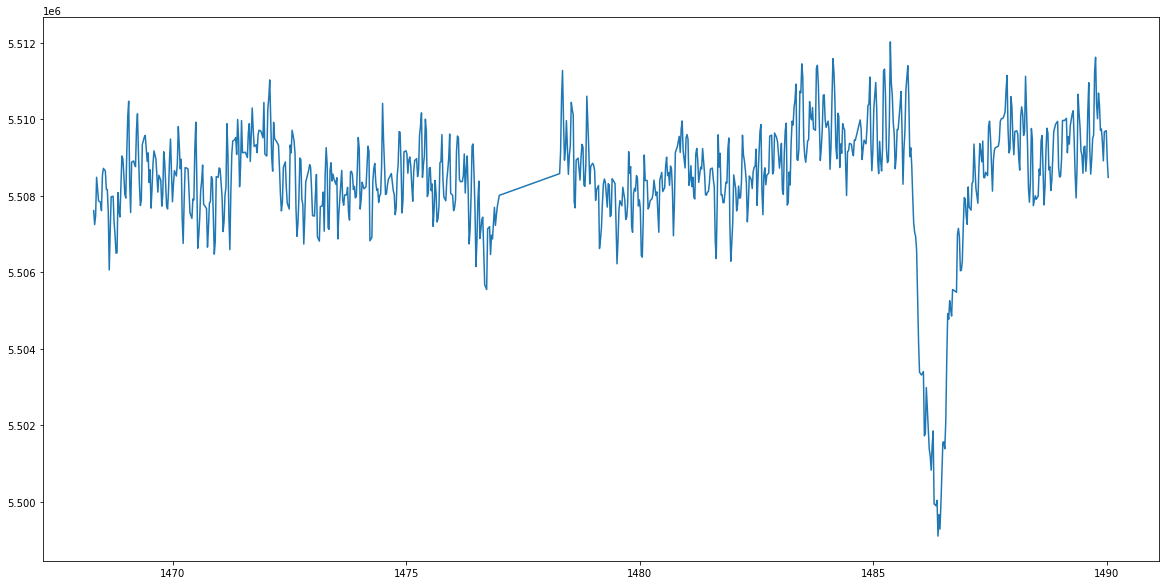

In [133]:
plt.plot(data["TIME"], data["PDCSAP_FLUX"])

In [134]:
# data = data['time','corrected flux','quality','flux error']

flat_flux, trend_flux = smoothing(data, method="median")
a = Table()
a["time"] = data[data.colnames[0]]
a["flux"] = flat_flux - np.ones(len(flat_flux))
a["quality"] = data[data.colnames[2]]
a["flux_error"] = data[data.colnames[3]]
# table[table.colnames[1]] = flat_flux - np.ones(len(flat_flux)) # resets normalisation to zero instead of one.
t, flux, quality, real, flux_error = clean_data(a)
flux *= real

### 3.3.1 My automated search

In [135]:
timestep = calculate_timestep(data)
factor = (1 / 48) / timestep

T1 = test_statistic_array(flux, 60 * factor)

m, n = np.unravel_index(
    T1.argmin(), T1.shape
)  # T.argmin(): location of  T.shape: 2D array with x,y points in that dimension
minT = T1[m, n]
# Ts = nonzero(T1[m,n]).std()
minT_time = t[n]
minT_duration = m * timestep
Tm_start = n - math.floor((m - 1) / 2)
Tm_end = Tm_start + m
Tm_depth = flux[Tm_start:Tm_end].mean()
Ts = nonzero(T1[m]).std()  # only the box width selected. Not RMS of all T-statistic

### 3.3.2 Creating the cutout of the deepest event

In [136]:
asym, width1, width2, depth, info = calc_shape(
    m, n, t, flux, quality, flux_error, n_m_bg_start=2
)
s = classify(m, n, real, asym)

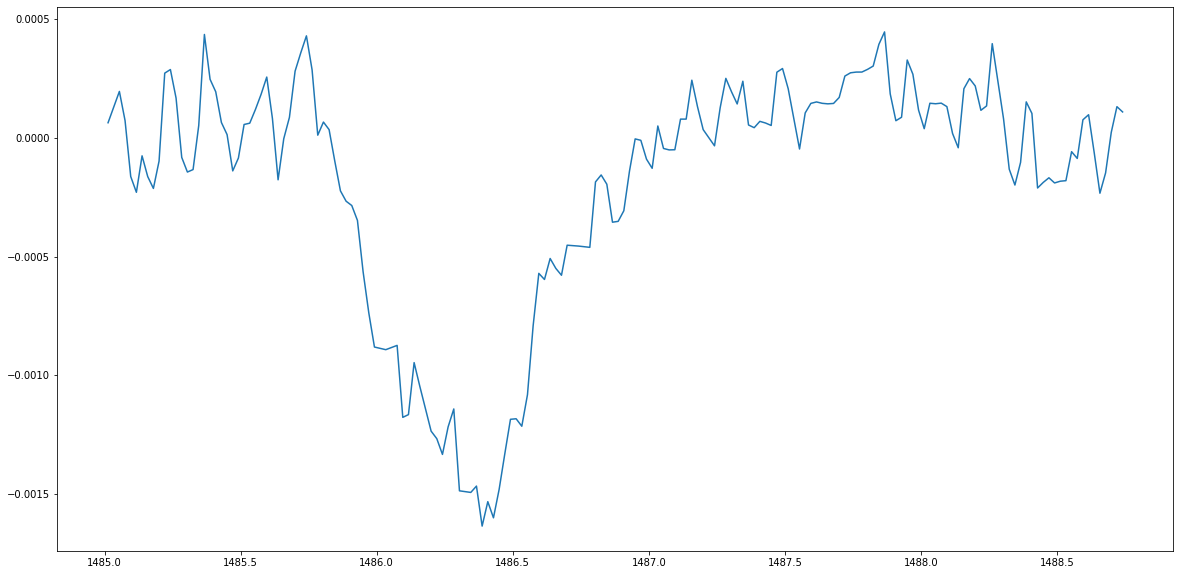

In [137]:
plt.plot(info[0], info[1])

In [138]:
min_time = info[-1]

In [139]:
t = info[0]
flux = info[1]

In [140]:
skewness = 3 * (np.mean(flux) - np.median(flux)) / np.std(flux)
skewness

-1.1090508215360522

### 4.1 Skewnorm

In [141]:
from scipy.stats import skewnorm, norm

In [142]:
t = info[0]
flux = info[1]

In [143]:
def gauss(t, A, t0, sigma):
    return abs(A) * np.exp(-((t - t0) ** 2) / (2 * sigma**2))

In [144]:
def single_gaussian_curve_fit(x, y):
    # Initial parameters guess
    i = np.argmax(y)
    A0 = y[i]
    mu0 = x[i]
    sigma0 = (x[-1] - x[0]) / 4

    params_bounds = [[0, x[0], 0], [np.inf, x[-1], sigma0 * 4]]
    params, cov = curve_fit(gauss, x, y, [A0, mu0, sigma0], bounds=params_bounds)
    return params, cov

In [145]:
def updated_skewed_gauss(x, a, mean, sigma, m):
    return -m * skewnorm.pdf(x, a, loc=mean, scale=sigma)

In [146]:
def skewed_gaussian_curve_fit(x, y):
    # Initial parameters guess
    ## i = index of min time
    ## x = time
    ## y = flux

    i = np.argmin(y)

    params_init = [4, x[i], 0.2, 0.0006]
    # params_bounds = [[0,x[0],0], [np.inf,x[-1],sigma0*4]]
    params, cov = curve_fit(
        updated_skewed_gauss, x, y, p0=params_init
    )  # ,bounds=params_bounds)
    return params, cov, x[i]

In [147]:
params, cov, x = skewed_gaussian_curve_fit(t, flux)
x

1486.3873952988386

In [95]:
params1, cov1 = single_gaussian_curve_fit(t, -flux)
params1

array([1.49877913e-03, 1.48633416e+03, 2.45425909e-01])

In [89]:
y2 = updated_skewed_gauss(t, *params)

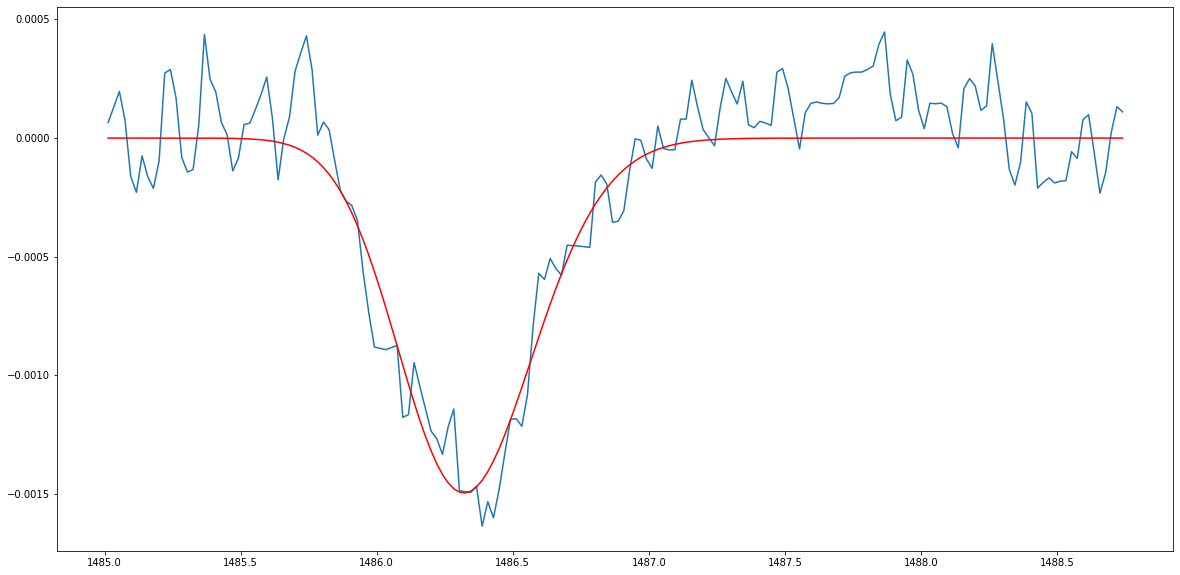

In [90]:
plt.plot(t, flux)
# plt.plot(t,-y)
# plt.plot(xx,updated_skewed_gauss(xx,4,1486.1,0.25,m=0.0006),color='black')
plt.plot(t, y2, color="red")

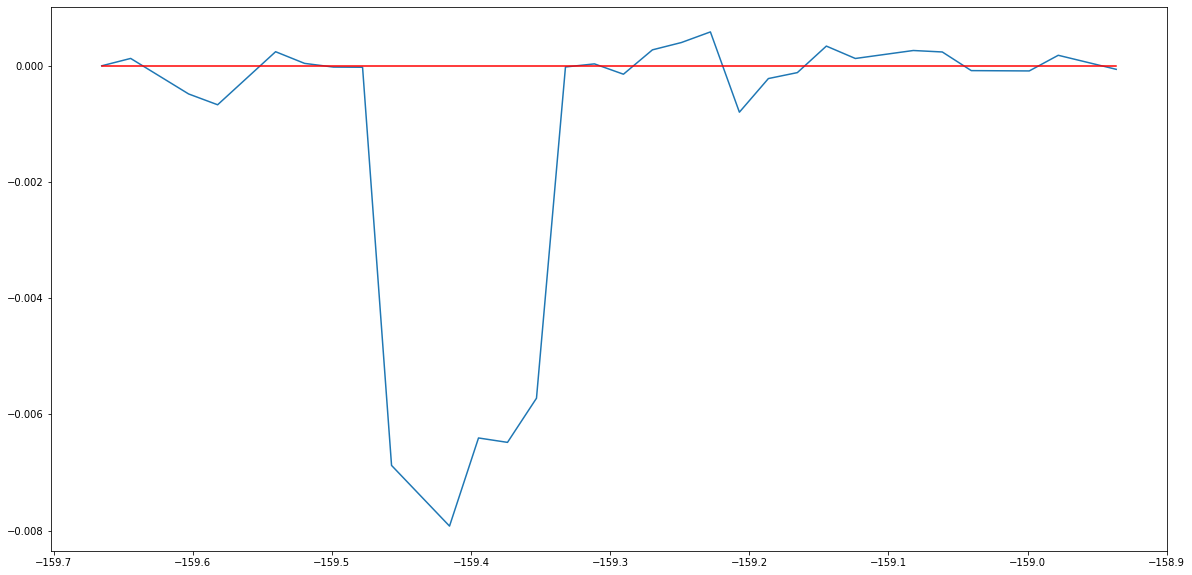

In [71]:
plt.plot(t - params[1], flux)
plt.plot(t - params[1], y2, color="red")
# plt.errorbar(t-params[1],flux,yerr=normalise_flux(flux_error)+1)